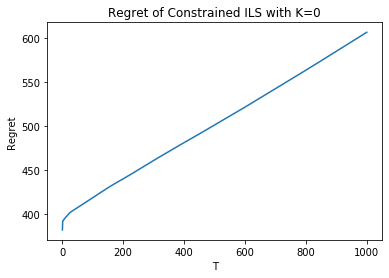

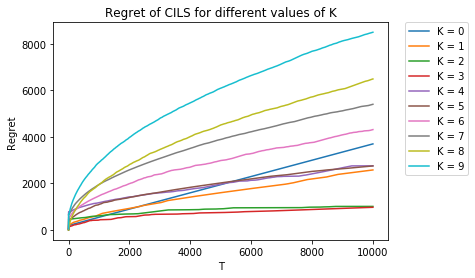

In [27]:
import random
import matplotlib.pyplot as plt
import numpy as np

#Question (a):

'''
GILS implements the greedy iterated least squares price policy.
The INPUTS are as follows:

1) b_1, b_2, b_3, b_4 (floats): the bounds for the paramaters of the demand function, i.e.
0 <= b_1 <= theta_1 <= b_2 AND b_3 <= theta_3 <= b_4 <= 0.

2) min_p, max_p (floats): the bounds for the true price.

3) t (int): time stamp.

3) h (array of 2-tuples): the history of prices and demands up to time t. Namely:
h = [(p_1,d_1); (p_2,d_2); . . . ; (p_t,d_t)].

The OUTPUT is p_{t+1} (int), the price chosen by GILS for the next time stamp.
'''

def GILS(b_1, b_2, b_3, b_4, min_p, max_p, t, h):
    
    # Choose a random price for the first 2 time stamps.
    if t == 0:
        return random.uniform(min_p,max_p)
    if t == 1:
        p_1 = h[0][0]
        p_2 = random.uniform(min_p,max_p)
        while p_2 == p_1:
            p_2 = random.uniform(min_p,max_p)
        return p_2
    
    # If t>1, compute the least squares estimator (theta_1, theta_2).
    # We use the usual solution for ls estimator in linear regression.
    prices = [h[i][0] for i in range(t)]
    demands = [h[i][1] for i in range(t)]
    prod = [prices[i]*demands[i] for i in range(t)]
    pric_squar = [prices[i]*prices[i] for i in range(t)]
    
    theta_2 = (sum(prod) - (sum(prices)*sum(demands))/t)/(sum(pric_squar) - sum(prices)*sum(prices)/t)
    theta_1 = sum(demands)/t - theta_2*sum(prices)/t
    
    # Project them onto [b_1,b_2] x [b_3,b_4] if necessary
    if theta_1 < b_1:
        theta_1 = b_1
    if theta_1 > b_2:
        theta_1 = b_2
    if theta_2 < b_3:
        theta_2 = b_3
    if theta_2 > b_4:
        theta_2 = b_4
    
    # Return the perceived optimal price (assuming it will fall into [min_p, max_p])
    return -theta_1/(2*theta_2)


"""
Sign function determines the sign of a float.
If the float is greater or equal than 0 the return equals 1,
otherwise the return equals -1.
"""

def Sign(x):
    if x >= 0:
        return 1
    else:
        return -1
'''
CILS implements the constrained iterated least squares price policy. The INPUTS are
the same as for GILS with the threshold paramter K (float) added. OUTPUT is also p_{t+1}
'''

def CILS(b_1, b_2, b_3, b_4, min_p, max_p, t, h, K):
    
    #  Calculate the unconstrained price. 
    U_price = GILS(b_1, b_2, b_3, b_4, min_p, max_p, t, h)
    # Calculate the average of the prices up till time t
    A_price = 0
    if t > 0:
        for history in h:
            A_price += history[0]/(t)
    
    # Calculate  delta_t
    delta_t = U_price  - A_price
    
    # Calculate the constrained price
    if abs(delta_t) < K*((t+1)**(-1/4)):
        return A_price + Sign(delta_t)*K*((t+1)**(-1/4))
    else:
        return U_price

'''
Let us assume for now that b_1 = 0.01, b_2 = 1000, b_3 = -500, b_4 = -0.01, min_p = 0, max_p = 50.
And also that the true theta_1 = 10 and theta_2 = -0.5 so that D = 10 - 0.5*p.
'''
    
#Questions (b) and (c):

'''
REGRET_fixed_K(K, T, theta_1, theta_2) computes all the regrets for CILS(K) up to time T for 
true paramters theta_1, theta_2 fixed, and parameter K. 
'''

def REGRET_fixed_K(K, T, theta_1, theta_2):
    best_p = -theta_1/(2*theta_2) # the best price in hindsight
    regrets = [] 
    h = []
    regret = 0
    for t in range(T):
        e_t = np.random.normal(0,1) # We assume the epsilon error at time t to be N(0,1) distributed.
        p_t = CILS(0.01,1000,-500,-0.01,0,50, t, h, K)
        d_t = theta_1 + theta_2*p_t +e_t
        regret += best_p*(theta_1 + theta_2*best_p) - p_t*(d_t-e_t)
        h.append((p_t,d_t))
        regrets.append(regret)
    return regrets

'''
REGRET_fixed_K(K, T, theta_1, theta_2) computes all the regrets at time T of all CILS(k) for k = 0 to 100. 
True paramters of the demand function are theta_1, theta_2. 
'''

def REGRET_fixed_T(K, T, theta_1, theta_2):
    regrets = []
    for k in range(K):
        temp = REGRET_fixed_K(k,T,theta_1,theta_2)
        regrets.append(temp[T-1]) 
    return regrets

def main():
    
    # Question (b)
    
    '''
    We compute the regret of CILS(0) for T = 1 to T = 1000. We then plot it against time 
    to assess its linear behavior.
    '''
    # Computation.
    time_max = 1000
    time = [t+1 for t in range(time_max)]
    regrets = []
    regrets = REGRET_fixed_K(0, time_max, 10, -0.5)
    
    # PLOT.
    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.plot(time,regrets)
    axes.set_xlabel('T')
    axes.set_ylabel('Regret')
    axes.set_title('Regret of Constrained ILS with K=0')
    plt.show()
    
    # Question (c)
   
    '''
    We compare the behavior of the regrets of CILS(k) for a smaller range of k.
    We then plot each regret function against time on the same graph to compare their asymptotic behavior,
    and determine for which CILS(k) is better for values of T.
    '''
    
    k_max = 10 # Computing for k = 0, 1, ..., 9
    time_max = 10000
    time = [t+1 for t in range(time_max)]
    regrets_k = [] 
    for k in range(k_max):
        regrets_k.append(REGRET_fixed_K(k, time_max, 10, -0.5)) 
        
    # PLOT.
    figx = plt.figure()
    axes = figx.add_subplot(111)
    axes.set_xlabel('T')  
    axes.set_ylabel('Regret')
    axes.set_title('Regret of CILS for different values of K')
 
    for k in range(k_max):
        axes.plot(time,regrets_k[k],label = "K = " + str(k))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()      
      
if __name__ == '__main__':
    main()
